In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# Any results you write to the current directory are saved as output.
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/recommendationsv4/sample_submission.csv
/kaggle/input/recommendationsv4/meta_Grocery_and_Gourmet_Food.json
/kaggle/input/recommendationsv4/test.csv
/kaggle/input/recommendationsv4/train.csv
/kaggle/input/train-target-predict/train_target_predict_from_lightfm.csv


In [2]:
train = pd.read_csv('/kaggle/input/recommendationsv4/train.csv')
test = pd.read_csv('/kaggle/input/recommendationsv4/test.csv')
submission = pd.read_csv('/kaggle/input/recommendationsv4/sample_submission.csv')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# EDA

Датасет

У вас будет история оценок пользователя вместе с его обзором. Вы можете использовать текст рецензии в качестве дополнительной информации. Все оценки пользователей нормированы для бинарной классификации, если человек поставил оценку продукту больше 3 (не включительно), то мы считаем, что продукт ему понравился, если меньше 4, то продукт не понравился.

Составлю список характеристик признаков train:

* rating - понравилась или не понравилась книга (1 - понравилась, 0 - не понравилась). 

test.csv - набор данных, для которого вы должны сделать предсказания. У каждого наобора userid, itemid есть свой id, для которого вы должны сделать предсказание:

- overall - рейтинг, который поставил пользователь
- verified - был ли отзыв верифицирован
- reviewTime - когда был отзыв написан
- reviewerName - имя пользователя
- reviewText - текст отзыва
- summary - сжатый отзыв
- vote - количество голосований за отзыв
- style - метаданные
- image - изображение продукта
- userid - id пользователя
- itemid - id товара
- id - id для предсказания

Посмотрим на train

In [ ]:
train.sample(15)

In [ ]:
test.sample(5)

ASIN является уникальным для листинга продукта, вы его получаете от Амазон вместо UPC кода. Назову это условно "товар".

# Ок, выделю товары в отдельный список и попробую просмотреть на рейтинги, лайки и тд.

Создам базу товаров (из теста и трейна) - для этого возьму itemid и asin, а потом сгруппирую по одному из признаков (по идее не важно по какому, это одно и то же, но проверим).

Для будущих интересностей еще сделаю еще несколько колонок в списке товаров - положительные и негативные оценки. Буду ориентироваться  на 1 или 0 от пользователя. Если 0 - негативная оценка. Если 1 - положительная.

In [3]:
pd.options.mode.chained_assignment = None 

# возьму нужные колонки из трейна и создам новый датасет с товарами
items_train_list = train[['asin', 'itemid', 'rating']]

items_train_list['likes_up'] = np.where(items_train_list['rating'] == 1, 1, 0)
items_train_list['likes_down'] = np.where(items_train_list['rating'] == 0, 1, 0)

# сгруппирую товары по asin и посмотрю, сколько itemid входит
items_train_list_grouped_by_likes = items_train_list.groupby(['asin']) \
    .agg({'itemid': 'count', 'likes_up': 'sum', 'likes_down': 'sum'}) \
    .sort_values(by=['asin'], ascending=False)\
    .reset_index()\
    .rename(columns={'itemid': 'all_likes'})

items_train_list_grouped_by_likes

,asin,all_likes,likes_up,likes_down
0,B01HJF6FRA,5,4,1
1,B01HJCUNOO,9,8,1
2,B01HJ7QPKU,5,4,1
3,B01HJ4FWGG,14,10,4
4,B01HJ2OFYI,7,6,1
...,...,...,...,...
41297,B00004S1C5,10,8,2
41298,9742356831,74,67,7
41299,5463213682,7,7,0
41300,4639725183,8,8,0


Добавлю также средний рейтинг товара

In [4]:
items_train_list_with_overall = train[['asin', 'itemid', 'overall']]

# сгруппирую товары по asin и посмотрю средний рейтинг
items_train_list_grouped_by_overall_mean = items_train_list_with_overall.groupby(['asin']) \
    .agg({'overall': 'mean'}) \
    .sort_values(by=['asin'], ascending=False) \
    .reset_index() \
    .rename(columns={'overall': 'item_rating_mean'})

items_train_list_grouped_by_overall_mean

,asin,item_rating_mean
0,B01HJF6FRA,4.600000
1,B01HJCUNOO,4.333333
2,B01HJ7QPKU,4.400000
3,B01HJ4FWGG,4.285714
4,B01HJ2OFYI,4.285714
...,...,...
41297,B00004S1C5,4.400000
41298,9742356831,4.581081
41299,5463213682,4.857143
41300,4639725183,4.875000


Склею два датасета товаров

In [5]:
items_train_list = items_train_list_grouped_by_overall_mean.merge(items_train_list_grouped_by_likes, left_on='asin', right_on='asin')
items_train_list = items_train_list.sort_values(by='all_likes', ascending=False)
items_train_list

,asin,item_rating_mean,all_likes,likes_up,likes_down
17273,B00BUKL666,4.572573,5491,4858,633
15836,B00D3M2QP4,4.578703,4733,4197,536
20284,B008QMX2SG,4.582725,4654,4127,527
6678,B00R7PWK7W,4.571653,2547,2240,307
35524,B000X3TPHS,4.744348,2300,2163,137
...,...,...,...,...,...
35631,B000WLW9I8,5.000000,1,1,0
19138,B00A66UEG8,1.000000,1,0,1
9623,B00KY6WC9W,5.000000,1,1,0
22285,B006LQVN7G,3.000000,1,0,1


Посмотрим на распределение количества лайков и книг

In [ ]:
items_train_list['all_likes'].hist(bins='doane')

In [ ]:
items_train_list[items_train_list['all_likes'] > 100]

Что мы видим выше - что только около 1200 товаров из 41000 имеют количество лайков больше 100. Остальные товары можно отнести к LongTail... Что это значит для нас на практике?

Это значит, что мы можем применить это для "холодного старта".

Существует очень маленькое количество айтемов, о которых знают все. Нет никакого смысла их рекомендовать, потому что пользователь, скорее всего, либо уже их видел и просто не поставил оценку, либо и так о них знает и собирается посмотреть, либо твердо решил не смотреть вовсе. Я не раз смотрел трейлер «Списка Шиндлера», но посмотреть так и не собрался. С другой стороны, популярность очень быстро спадает, и подавляющее количество айтемов практически никто не видел. Делать рекомендации из этой части полезней: там есть интересный контент, который пользователь вряд ли сможет найти сам.

А еще для "холодного старта" мы можем на старте как-то опросить пользователя на предмет того, какие ему товары нравятся (выбор из списка), как делает тот же Pinterest (или другие, где со старта мне предлагают оценить мои интересы). Или если мы говорим про товары, то можем ему со старта показать 5 самых популярных наших товаров (которые имеют больше всего голосов), которые он может отметить голосами - нравится или не нравится. И мы уже будем знать, что ему примерно нравится.

Как не сортировать по среднему рейтингу и учитывать количество оценок? Посчитать доверительный интервал: «Исходя из имеющихся оценок, с вероятностью в 95 % истинная доля положительных оценок как минимум какая?». Ответ на этот вопрос дал Эдвин Уилсон в 1927 году: http://www.evanmiller.org/how-not-to-sort-by-average-rating.html

In [6]:
from math import sqrt

def confidence(ups, downs):
    n = ups + downs

    if n == 0:
        return 0

    z = 1.96 #1.44 = 85%, 1.96 = 95%
    phat = float(ups) / n
    return ((phat + z*z/(2*n) - z * sqrt((phat*(1-phat)+z*z/(4*n))/n))/(1+z*z/n))

items_train_list['item_score'] = items_train_list.apply(lambda row : confidence(row['likes_up'], row['likes_down']), axis = 1)

items_train_list

,asin,item_rating_mean,all_likes,likes_up,likes_down,item_score
17273,B00BUKL666,4.572573,5491,4858,633,0.876003
15836,B00D3M2QP4,4.578703,4733,4197,536,0.877409
20284,B008QMX2SG,4.582725,4654,4127,527,0.877339
6678,B00R7PWK7W,4.571653,2547,2240,307,0.866247
35524,B000X3TPHS,4.744348,2300,2163,137,0.930008
...,...,...,...,...,...,...
35631,B000WLW9I8,5.000000,1,1,0,0.206543
19138,B00A66UEG8,1.000000,1,0,1,0.000000
9623,B00KY6WC9W,5.000000,1,1,0,0.206543
22285,B006LQVN7G,3.000000,1,0,1,0.000000


Посмотрим-ка на распределение score

In [ ]:
items_train_list['item_score'].hist(bins='doane')

Довольно интересное распределение. С натяжкой вроде бы можно отнести к нормальному распределению.

Пока что провел некоторые операции с базой товаров - это больше интересно для холодного старта, ориентируясь на рейтинги товара. Пока что я вижу так. А теперь продолжим работать с пользователями, лайками из датасета..

# Работа с train

### Image

Сразу видно, что в колонке image очень много пропусков. Побороть это не представляется возможным. Но так как это только 1% от общей выборки, то можно смело удалить признак.

In [3]:
train = train.drop(columns='image')

### unixReviewTime, reviewTime

Проверю, что выдает unixReviewTime при переводе его в нормальный формат времени.

In [4]:
train['reviewTime_new'] = pd.to_datetime(train.unixReviewTime, unit='s')

Видим, что новая колонка полностью дублирует колонку reviewTime, но уже в нормальном формате. Следовательно, теперь reviewTime можно смело удалить.

Удалять буду так, как того требует команда pandas путем замены текущего датафрейма, без inplace=True

In [5]:
train = train.drop(columns=['reviewTime'])

И сразу переименую колонку reviewTime_new в нормальное название

In [6]:
train = train.rename(columns={'reviewTime_new': 'review_time', 'unixReviewTime': 'unix_review_time'})

In [ ]:
train

### Rating

Выяснили, что rating - это нравится книга или нет. Переведу это в int.

In [7]:
train['rating'] = train['rating'].astype(int)

Посмотрю пристальнее на признаки. Создам функцию просмотра данных:

In [8]:
def col_info(col, bins):
    print('Количество пропусков: {}'.format(col.isnull().sum()))
    print('{},'.format(col.describe()))
    print('Распределение:\n{},'.format(col.value_counts()))
    col.hist(bins=bins)

### Overall

In [ ]:
col_info(train.overall, 'doane')

Переведу в int признак overall.

In [9]:
train['overall'] = train['overall'].astype(int)

### Verified

In [ ]:
train.verified.nunique()

In [ ]:
train.verified.unique()

Что это зна признак пока не понятно. Пропусков нет. Варианты - True или False. Есть предположение, что речь идет о том, что отзыв был заапрувлен (опубликован на сайте) или нет.

Надо ли ориентироваться на этот признак? В сущности, человек так или иначе оставил свой отзыв и это его мнение о книге. Значит, можно удалить и этот признак.

In [10]:
train = train.drop(columns='verified')

### Vote

In [ ]:
col_info(train.vote, 'doane')

Очень много пропусков... Сделать с этим ничего нельзя - удалю признак.

In [11]:
train = train.drop(columns='vote')

### reviewerName	

Думаю, что нет смысла ориентироваться на этот признак - он ничего нам не дает.

In [12]:
train = train.drop(columns='reviewerName')

In [ ]:
train.sample(5)

Попробую добавить новые признаки на основании даты отзыва - год, месяц, день, день недели.

In [13]:
train['review_year'] = pd.DatetimeIndex(train['review_time']).year
train['review_month'] = pd.DatetimeIndex(train['review_time']).month
train['review_day'] = pd.DatetimeIndex(train['review_time']).day
train['review_dayofweek'] = pd.DatetimeIndex(train['review_time']).dayofweek.astype(object)

# перенесу этот признак наперед, потому что он у меня объект и мне будет удобнее провести OneEncoding для CatBoost
cols = ['review_dayofweek']  + [col for col in train if col != 'review_dayofweek']
train = train[cols]

train = train.drop(columns='review_time')
train

,review_dayofweek,overall,asin,reviewText,summary,unix_review_time,style,userid,itemid,rating,review_year,review_month,review_day
0,1,5,B01CPNIEQG,These are my FAVORITE spices in my collection....,Must Add to your Spice kitchen!,1475539200,NaN,102179,37138,1,2016,10,4
1,1,5,B006F63M8U,Add A package to my Coffee and it makes a good...,Milk Chocolate Swiis MIss Hot Cocoa Mix,1456790400,{'Size:': ' 60-0.73 oz Envelopes'},3625,17322,1,2016,3,1
2,6,5,B00112O8NG,"I love the Torani syrups, but not the prices o...","Love these sugar free syrups, but didn't love ...",1466899200,NaN,39495,5600,1,2016,6,26
3,3,5,B00MRAQUM8,Very fragrant. The price can't be beat. I do l...,Nice !,1378339200,NaN,72854,30249,1,2013,9,5
4,2,5,B000R7RN0G,These are my favorite jalapeno chips so far. T...,These are my favorite jalapeno chips so far,1473811200,{'Flavor:': ' Jalapeo'},74859,4349,1,2016,9,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...
857890,1,5,B000H7ELTW,Next to the round variety hanging on my cherry...,next to the round variety............,1364860800,{'Flavor:': ' Dried Cherries'},59433,2566,1,2013,4,2
857891,6,2,B0012NI02O,Not my cup of tea.,Two Stars,1449964800,{'Package Quantity:': ' 1'},86473,5828,0,2015,12,13
857892,2,4,B000LKX6R8,"I really like these noodles, I just gave it on...",good but better value elsewhere,1474416000,{'Size:': ' Pack of 8'},88,3251,1,2016,9,21
857893,6,4,B00BUKL666,"I like these, they are the kind for a snack an...",Great selection,1446336000,NaN,41540,22208,1,2015,11,1


Так как в тестовой выборке нет колонки overall, удалю ее и в трейне

In [14]:
train = train.drop(columns='overall')

### style

Тоже самое с колонкой style

In [15]:
train = train.drop(columns='style')

### reviewText, summary

Так как в тесте нету reviewText, summary, то удалю их - все равно не смогу применить эти признаки.

In [16]:
train = train.drop(columns=['summary', 'reviewText'])

In [ ]:
train

# Работа с test

In [ ]:
test = pd.read_csv('/kaggle/input/recommendationsv4/test.csv')

In [17]:
test = test.drop(columns='image')
test['reviewTime_new'] = pd.to_datetime(test.unixReviewTime, unit='s')
test = test.drop(columns=['reviewTime'])
test = test.rename(columns={'reviewTime_new': 'review_time', 'unixReviewTime': 'unix_review_time'})
test = test.drop(columns=['vote', 'reviewerName'])
test = test.drop(columns='verified')
test['review_year'] = pd.DatetimeIndex(test['review_time']).year
test['review_month'] = pd.DatetimeIndex(test['review_time']).month
test['review_day'] = pd.DatetimeIndex(test['review_time']).day
test['review_dayofweek'] = pd.DatetimeIndex(test['review_time']).dayofweek.astype(object)

# перенесу этот признак наперед, потому что он у меня объект и мне будет удобнее провести OneEncoding для CatBoost
cols = ['review_dayofweek']  + [col for col in test if col != 'review_dayofweek']
test = test[cols]

test = test.drop(columns='review_time')
test = test.drop(columns='Id')
test = test.drop(columns='style')


In [ ]:
test.info()

# Fit/Predict

Ну что же, первичные преобразование сделал. Попробую теперь получить какое-то предсказание с помощью LightFM - это будет мой бейслайн.

In [18]:
import scipy.sparse as sparse

from lightfm import LightFM
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k
import sklearn
from sklearn.model_selection import train_test_split

import scipy.sparse as sparse

In [19]:
train_data, test_data = train_test_split(train,random_state=32, shuffle=True)

In [20]:
ratings_coo = sparse.coo_matrix((train_data['rating'].astype(int),
                                 (train_data['userid'],
                                  train_data['itemid'])))

In [21]:
NUM_THREADS = 4 #число потоков
NUM_COMPONENTS = 70 #число параметров вектора 
NUM_EPOCHS = 20 #число эпох обучения

model = LightFM(learning_rate=0.1, loss='logistic',
                learning_schedule='adagrad',
                no_components=NUM_COMPONENTS)
model = model.fit(ratings_coo, epochs=NUM_EPOCHS, 
                  num_threads=NUM_THREADS)

In [22]:
preds_lightfm = model.predict(test_data.userid.values,
                      test_data.itemid.values)


In [ ]:
preds_lightfm

In [ ]:
preds_lightfm.min(), preds_lightfm.max()

In [23]:
normalized_preds_lightfm = (preds_lightfm - preds_lightfm.min())/(preds_lightfm - preds_lightfm.min()).max()

In [ ]:
normalized_preds_lightfm

In [24]:
sklearn.metrics.roc_auc_score(test_data.rating,preds_lightfm)


0.7498841240272603

In [ ]:
normalized_preds_lightfm.min(), normalized_preds_lightfm.max()

In [25]:
preds_lightfm = model.predict(test.userid.values,
                      test.itemid.values)


In [ ]:
preds_lightfm.min(), preds_lightfm.max()

In [26]:
test_normalized_preds_lightfm = (preds_lightfm - preds_lightfm.min())/(preds_lightfm - preds_lightfm.min()).max()

In [27]:
normalized_preds_lightfm.min(), normalized_preds_lightfm.max()

(0.0, 1.0)

# Predict Upper

Попробую теперь улучшить модель. Для этого буду вводить новые признаки в датафреймы и с помощью различных ухищрений и библиотеки CatBoost попробую улучшить прогноз для колонки rating.

Добавлю к таблицам трейн и тест данные из таблицы товаров

In [28]:
test_full = test.copy()
train_full = train.copy()

In [ ]:
train_full

In [33]:
train_full = train.merge(items_train_list, how='left', left_on='asin', right_on='asin')
test_full = test.merge(items_train_list, how='left', left_on='asin', right_on='asin')

После того как добавил в тестовый датасет данные из колонки товары, выяснилось, что в тесте нет данных для 60 товаров. На фоне общего количества это мизер. Поэтому просто добавлю сюда срение значения по выборе и все.

In [302]:
test_full['item_rating_mean'].fillna((test_full['item_rating_mean'].mean()), inplace=True)
test_full['all_likes'].fillna((test_full['all_likes'].mean()), inplace=True)
test_full['likes_up'].fillna((test_full['likes_up'].mean()), inplace=True)
test_full['likes_down'].fillna((test_full['likes_down'].mean()), inplace=True)
test_full['item_score'].fillna((test_full['item_score'].mean()), inplace=True)

Ранее с помощью K-FOLD техними получил с помощью LightFM предсказания для всех трейновых записей. Чтобы не засорять страницу с кодом, вынес это в отдельный файл. Теперь подключил его и далее добавлю данные в датасеты для второй модели.

In [29]:
train_target_predict_from_lightfm = pd.read_csv('../input/train-target-predict/train_target_predict_from_lightfm.csv')

Теперь добавлю предсказания, полученные от LightFM для каждого наблюдения. И буду на них тренировать вторую модель.

In [30]:
train_full['lightfm_rating'] = train_target_predict_from_lightfm

test_full['lightfm_rating'] = pd.DataFrame(test_normalized_preds_lightfm)

In [35]:
train_full

,review_dayofweek,asin,unix_review_time,userid,itemid,rating,review_year,review_month,review_day,lightfm_rating
0,1,B01CPNIEQG,1475539200,102179,37138,1,2016,10,4,0.427157
1,1,B006F63M8U,1456790400,3625,17322,1,2016,3,1,0.464795
2,6,B00112O8NG,1466899200,39495,5600,1,2016,6,26,0.407720
3,3,B00MRAQUM8,1378339200,72854,30249,1,2013,9,5,0.451040
4,2,B000R7RN0G,1473811200,74859,4349,1,2016,9,14,0.430200
...,...,...,...,...,...,...,...,...,...,...
857890,1,B000H7ELTW,1364860800,59433,2566,1,2013,4,2,0.535501
857891,6,B0012NI02O,1449964800,86473,5828,0,2015,12,13,0.480362
857892,2,B000LKX6R8,1474416000,88,3251,1,2016,9,21,0.505369
857893,6,B00BUKL666,1446336000,41540,22208,1,2015,11,1,0.591285


Нам по ходу не нужен признак itemid, так как оно коррелирует с asin. А зачем userid? Тоже вроде не нужен

In [31]:
test_full = test_full.drop(columns=['itemid'])
train_full = train_full.drop(columns=['itemid'])

In [305]:
test_full = test_full.drop(columns=['itemid', 'asin', 'all_likes', 'likes_up', 'likes_down'])
train_full = train_full.drop(columns=['itemid', 'asin', 'all_likes', 'likes_up', 'likes_down'])

Попробую сгенерировать признаки на основании временного окна

In [32]:
train_full['lightfm_rolling_mean'] = train_full['lightfm_rating'].rolling(window=7).mean()
train_full['lightfm_rolling_mean'] = train_full['lightfm_rolling_mean'].fillna(0)

test_full['lightfm_rolling_mean'] = test_full['lightfm_rating'].rolling(window=7).mean()
test_full['lightfm_rolling_mean'] = test_full['lightfm_rolling_mean'].fillna(0)

In [33]:
train_full['lightfm_expanding_mean'] = train_full['lightfm_rating'].expanding(2).mean()
train_full['lightfm_expanding_mean'] = train_full['lightfm_expanding_mean'].fillna(0)

test_full['lightfm_expanding_mean'] = test_full['lightfm_rating'].expanding(2).mean()
test_full['lightfm_expanding_mean'] = test_full['lightfm_expanding_mean'].fillna(0)

Этот код выбирает числовые признаки, вычисляет их логарифмы, выбирает два категориальных признака, применяет к ним one-hot кодирование и объединяет оба множества в одно, а таже суммирует значения признаков между собой.

In [37]:
import itertools

def itr_combinations_new_features(data):
    
    tmp_df = data.copy()
    
    old_columns = [item for item in tmp_df.columns.tolist() if item != 'rating']
    
#     tmp_df_sum_2 = [(pd.Series(tmp_df.loc[:,list(i)].sum(axis=1),\
#             name='_sum2_'.join(tmp_df.loc[:,list(i)].columns))) for i in list(itertools.combinations(old_columns,2))]
    
#     tmp_df_sum_3 = [(pd.Series(tmp_df.loc[:,list(i)].sum(axis=1),\
#             name='_sum3_'.join(tmp_df.loc[:,list(i)].columns))) for i in list(itertools.combinations(old_columns,3))]
    
    tmp_df_multiplication = [(pd.Series(tmp_df.loc[:,i[0]]*tmp_df.loc[:,i[1]],\
            name='_mult_'.join(tmp_df.loc[:,list(i)].columns))) for i in list(itertools.combinations(old_columns,2))]
    
   
#     df_sum_2 = pd.DataFrame(tmp_df_sum_2).T  
    
#     df_sum_3 = pd.DataFrame(tmp_df_sum_3).T  
    
    df_multiplication = pd.DataFrame(tmp_df_multiplication).T  
   
    data = pd.concat([data, df_multiplication], axis=1, sort=False)         
 
    
    return data

In [ ]:
train_full = itr_combinations_new_features(train_full)
train_full = train_full.fillna(0)

In [311]:
train_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 857895 entries, 0 to 857894
Data columns (total 85 columns):
 #   Column                                                                  Non-Null Count   Dtype  
---  ------                                                                  --------------   -----  
 0   review_dayofweek                                                        857895 non-null  int64  
 1   userid                                                                  857895 non-null  int64  
 2   rating                                                                  857895 non-null  int64  
 3   item_rating_mean                                                        857895 non-null  float64
 4   item_score                                                              857895 non-null  float64
 5   lightfm_rating                                                          857895 non-null  float64
 6   lightfm_rolling_mean                                                

In [312]:
test_full = itr_combinations_new_features(test_full)
test_full = test_full.fillna(0)

In [313]:
test_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 285965 entries, 0 to 285964
Data columns (total 84 columns):
 #   Column                                                                  Non-Null Count   Dtype  
---  ------                                                                  --------------   -----  
 0   review_dayofweek                                                        285965 non-null  int64  
 1   userid                                                                  285965 non-null  int64  
 2   item_rating_mean                                                        285965 non-null  float64
 3   item_score                                                              285965 non-null  float64
 4   lightfm_rating                                                          285965 non-null  float64
 5   lightfm_rolling_mean                                                    285965 non-null  float64
 6   lightfm_expanding_mean                                              

In [34]:
def code_mean(data, cat_feature, real_feature):
    """
    Returns a dictionary where keys are unique categories of the cat_feature,
    and values are means over real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

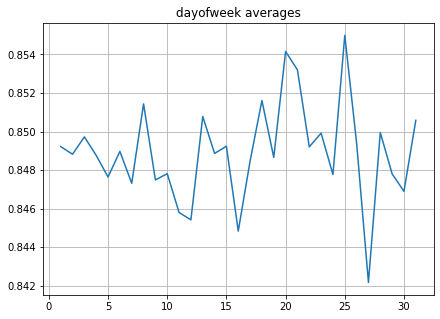

In [189]:
average_dayofweek = code_mean(train_full, 'review_day', "rating")
plt.figure(figsize=(7, 5))
plt.title("dayofweek averages")
pd.DataFrame.from_dict(average_dayofweek, orient='index')[0].plot()
plt.grid(True);

In [35]:
train_full["lightfm_rating_by_day_average"] = list(map(code_mean(train_full, 'review_day', "lightfm_rating").get, train_full.review_day))
test_full["lightfm_rating_by_day_average"] = list(map(code_mean(test_full, 'review_day', "lightfm_rating").get, test_full.review_day))

train_full["review_by_month_average"] = list(map(code_mean(train_full, 'review_month', "lightfm_rating").get, train_full.review_month))
test_full["lightfm_rating_by_month_average"] = list(map(code_mean(test_full, 'review_month', "lightfm_rating").get, test_full.review_month))

train_full["lightfm_rating_by_dayofweek_average"] = list(map(code_mean(train_full, 'review_dayofweek', "lightfm_rating").get, train_full.review_dayofweek))
test_full["lightfm_rating_by_dayofweek_average"] = list(map(code_mean(test_full, 'review_dayofweek', "lightfm_rating").get, test_full.review_dayofweek))

Подчищу уже ненужные признаки

In [36]:
test_full = test_full.drop(columns=['review_year', 'review_month', 'review_day', 'unix_review_time'])
train_full = train_full.drop(columns=['review_year', 'review_month', 'review_day', 'unix_review_time'])

In [95]:
test_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 285965 entries, 0 to 285964
Data columns (total 99 columns):
 #   Column                                           Non-Null Count   Dtype  
---  ------                                           --------------   -----  
 0   review_dayofweek                                 285965 non-null  int64  
 1   unix_review_time                                 285965 non-null  int64  
 2   userid                                           285965 non-null  int64  
 3   review_year                                      285965 non-null  int64  
 4   review_month                                     285965 non-null  int64  
 5   review_day                                       285965 non-null  int64  
 6   item_rating_mean                                 285965 non-null  float64
 7   item_score                                       285965 non-null  float64
 8   lightfm_rating                                   285965 non-null  float64
 9   lightfm_rolling

In [ ]:
col_info(train_full.lightfm_rating, 'doane')

In [ ]:
col_info(train_full.item_score, 'doane')

Плохо распределен признак item_score. Логарифмировать не получится. Надо подумать, что можно сделать.

In [ ]:
train_full

In [ ]:
test_full

Применю теперь модель CatBoost Regressor

In [90]:
from catboost import CatBoostRegressor
from sklearn.metrics import accuracy_score

In [ ]:
test_full.info()

In [314]:
from sklearn.model_selection import train_test_split

X = train_full.drop(['rating'], axis=1,)
y = train_full.rating.values

X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.75, random_state=42)

X_test = test_full.drop([], axis=1,)

Байесовская оптимизация параметров CatBoost с Hyperopt

In [227]:
import hyperopt

def hyperopt_objective(params):
    model = CatBoostRegressor(
        l2_leaf_reg=int(params['l2_leaf_reg']),
        learning_rate=params['learning_rate'],
        iterations=100,
        eval_metric='AUC',
        random_seed=42,
        verbose=False,
        loss_function='RMSE',
    )
    
    cv_data = cv(
        Pool(X_train, y_train),
        model.get_params()
    )
    best_accuracy = np.max(cv_data['test-AUC-mean'])
    
    return 1 - best_accuracy # as hyperopt minimises

In [228]:
from numpy.random import RandomState

params_space = {
    'l2_leaf_reg': hyperopt.hp.qloguniform('l2_leaf_reg', 0, 2, 1),
    'learning_rate': hyperopt.hp.uniform('learning_rate', 0.001, 0.5),
}

trials = hyperopt.Trials()

best = hyperopt.fmin(
    hyperopt_objective,
    space=params_space,
    algo=hyperopt.tpe.suggest,
    max_evals=10,
    trials=trials,
    rstate=RandomState(123)
)

print(best)

100%|██████████| 10/10 [06:07<00:00, 36.75s/trial, best loss: 0.20404329741657679]
{'l2_leaf_reg': 5.0, 'learning_rate': 0.49626653559232625}


In [315]:
# CatBoost Regression

params = {
    'iterations': 750,
    'learning_rate': 0.2,
    'l2_leaf_reg': 3,
    'eval_metric': 'AUC',
    'loss_function': 'RMSE',
    'use_best_model': True,
    'random_seed': 42,
    'logging_level': 'Silent'
}


model = CatBoostRegressor(**params)

categorical_features_names = [0]

# Fit model
model.fit(
    X_train, y_train,
    cat_features=categorical_features_names,
    eval_set=(X_validation, y_validation),
#     logging_level='Verbose',  # you can uncomment this for text output
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Посмотрим, какие признаки CatBoost считает важными.

In [316]:
from catboost import Pool, CatBoostRegressor, cv

feature_score = pd.DataFrame(list(zip(X.dtypes.index, model.get_feature_importance(Pool(X_train, label=y_train, cat_features=categorical_features_names)))),
                columns=['Feature','Score'])

feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

feature_score

,Feature,Score
4,lightfm_rating,16.398335
75,item_rating_mean_mult_lightfm_rating,10.275732
26,lightfm_rating_sum2_lightfm_expanding_mean,9.387139
6,lightfm_expanding_mean,7.646005
19,item_rating_mean_sum2_lightfm_rating,6.128180
...,...,...
14,userid_sum2_item_score,0.006601
17,userid_sum2_lightfm_expanding_mean,0.006018
44,userid_sum3_item_rating_mean_sum3_lightfm_rating,0.005045
52,userid_sum3_lightfm_rolling_mean_sum3_lightfm_...,0.000000


Удалю ненужные по-моему мнению признаки.

In [317]:
def del_bag_feat(data):

    feature_score_upd = feature_score[(feature_score['Score']<0.4)]
    feature_score_upd = feature_score_upd['Feature'].tolist()
    
    print(feature_score_upd)
    
    indexes_to_keep = set(data.columns) - set(feature_score_upd)    
   
    data = data[indexes_to_keep]
    

    return data

In [318]:
train_full2 = del_bag_feat(train_full)

['review_dayofweek_mult_item_score', 'review_dayofweek_sum3_item_rating_mean_sum3_item_score', 'item_rating_mean_sum3_lightfm_rolling_mean_sum3_lightfm_expanding_mean', 'review_dayofweek_sum3_lightfm_rating_sum3_lightfm_expanding_mean', 'review_dayofweek_sum2_lightfm_rating', 'review_dayofweek_sum3_item_score_sum3_lightfm_expanding_mean', 'review_dayofweek_mult_lightfm_rolling_mean', 'review_dayofweek_sum3_item_score_sum3_lightfm_rolling_mean', 'review_dayofweek_sum3_lightfm_rating_sum3_lightfm_rolling_mean', 'review_dayofweek_sum3_item_rating_mean_sum3_lightfm_expanding_mean', 'review_dayofweek_sum2_item_rating_mean', 'review_dayofweek_sum3_item_rating_mean_sum3_lightfm_rating', 'review_dayofweek_mult_lightfm_rating', 'review_dayofweek_sum3_item_rating_mean_sum3_lightfm_rolling_mean', 'review_dayofweek_sum2_item_score', 'review_dayofweek_sum2_lightfm_expanding_mean', 'review_dayofweek_sum2_lightfm_rolling_mean', 'review_dayofweek_sum3_lightfm_rolling_mean_sum3_lightfm_expanding_mean',

In [319]:
train_full2

,item_rating_mean_sum2_lightfm_rolling_mean,item_rating_mean_sum3_item_score_sum3_lightfm_rating,item_score_sum3_lightfm_rating_sum3_lightfm_expanding_mean,item_score_sum2_lightfm_expanding_mean,lightfm_rolling_mean_mult_lightfm_expanding_mean,item_rating_mean,item_rating_mean_mult_lightfm_expanding_mean,item_rating_mean_mult_lightfm_rolling_mean,item_score_mult_lightfm_expanding_mean,userid_mult_lightfm_rating,...,item_score_sum2_lightfm_rating,item_rating_mean_sum3_item_score_sum3_lightfm_expanding_mean,item_rating_mean_mult_item_score,userid_mult_lightfm_rolling_mean,lightfm_rating_sum2_lightfm_rolling_mean,item_score_mult_lightfm_rating,lightfm_rating_sum2_lightfm_expanding_mean,lightfm_rating_mult_lightfm_rolling_mean,lightfm_rolling_mean,lightfm_rating_mult_lightfm_expanding_mean
0,4.750000,5.706262,0.956262,0.529105,0.000000,4.750000,0.000000,0.000000,0.000000,43646.475786,...,0.956262,5.279105,2.513250,0.000000,0.427157,0.226011,0.427157,0.000000,0.000000,0.000000
1,4.671642,5.973344,1.747678,1.282883,0.000000,4.671642,2.083440,0.000000,0.373241,1684.881035,...,1.301702,5.954525,3.909732,0.000000,0.464795,0.388990,0.910771,0.000000,0.000000,0.207287
2,4.485391,5.731469,1.679302,1.271582,0.000000,4.485391,1.943179,0.000000,0.363197,16102.908876,...,1.246078,5.756973,3.760364,0.000000,0.407720,0.341816,0.840944,0.000000,0.000000,0.176634
3,4.718750,6.056922,1.775850,1.324810,0.000000,4.718750,2.065293,0.000000,0.388278,32860.052473,...,1.338172,6.043560,4.186155,0.000000,0.451040,0.400132,0.888718,0.000000,0.000000,0.197410
4,4.424242,5.545240,1.557180,1.126980,0.000000,4.424242,1.929777,0.000000,0.301314,32204.353110,...,1.120998,5.551223,3.056257,0.000000,0.430200,0.297181,0.866383,0.000000,0.000000,0.187646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
857890,5.254201,6.176373,1.957723,1.422222,0.268088,4.734554,2.442574,2.460298,0.467573,31826.420926,...,1.441819,6.156776,4.291013,30884.193437,1.055148,0.485334,1.051405,0.278272,0.519647,0.276267
857891,4.971092,5.457921,1.519279,1.038918,0.266488,4.454545,2.298117,2.300979,0.269825,41538.330316,...,1.003376,5.493463,2.329789,44667.312374,0.996908,0.251236,0.996266,0.248129,0.516546,0.247820
857892,4.822639,5.520740,1.735056,1.229687,0.268812,4.301587,2.219205,2.241349,0.368244,44.472490,...,1.219153,5.531274,3.070402,45.852540,1.026421,0.360724,1.021273,0.263323,0.521052,0.260722
857893,5.104563,6.039861,1.983191,1.391907,0.274456,4.572573,2.359008,2.432562,0.451933,24561.959029,...,1.467288,5.964480,4.005588,22098.851580,1.123274,0.517967,1.107188,0.314557,0.531990,0.305046


In [320]:
test_full2 = del_bag_feat(test_full)

['review_dayofweek_mult_item_score', 'review_dayofweek_sum3_item_rating_mean_sum3_item_score', 'item_rating_mean_sum3_lightfm_rolling_mean_sum3_lightfm_expanding_mean', 'review_dayofweek_sum3_lightfm_rating_sum3_lightfm_expanding_mean', 'review_dayofweek_sum2_lightfm_rating', 'review_dayofweek_sum3_item_score_sum3_lightfm_expanding_mean', 'review_dayofweek_mult_lightfm_rolling_mean', 'review_dayofweek_sum3_item_score_sum3_lightfm_rolling_mean', 'review_dayofweek_sum3_lightfm_rating_sum3_lightfm_rolling_mean', 'review_dayofweek_sum3_item_rating_mean_sum3_lightfm_expanding_mean', 'review_dayofweek_sum2_item_rating_mean', 'review_dayofweek_sum3_item_rating_mean_sum3_lightfm_rating', 'review_dayofweek_mult_lightfm_rating', 'review_dayofweek_sum3_item_rating_mean_sum3_lightfm_rolling_mean', 'review_dayofweek_sum2_item_score', 'review_dayofweek_sum2_lightfm_expanding_mean', 'review_dayofweek_sum2_lightfm_rolling_mean', 'review_dayofweek_sum3_lightfm_rolling_mean_sum3_lightfm_expanding_mean',

In [321]:
test_full2

,item_rating_mean_sum2_lightfm_rolling_mean,item_rating_mean_sum3_item_score_sum3_lightfm_rating,item_score_sum3_lightfm_rating_sum3_lightfm_expanding_mean,item_score_sum2_lightfm_expanding_mean,lightfm_rolling_mean_mult_lightfm_expanding_mean,item_rating_mean,item_rating_mean_mult_lightfm_expanding_mean,item_rating_mean_mult_lightfm_rolling_mean,item_score_mult_lightfm_expanding_mean,userid_mult_lightfm_rating,...,item_score_sum2_lightfm_rating,item_rating_mean_sum3_item_score_sum3_lightfm_expanding_mean,item_rating_mean_mult_item_score,userid_mult_lightfm_rolling_mean,lightfm_rating_sum2_lightfm_rolling_mean,item_score_mult_lightfm_rating,lightfm_rating_sum2_lightfm_expanding_mean,lightfm_rating_mult_lightfm_rolling_mean,lightfm_rolling_mean,lightfm_rating_mult_lightfm_expanding_mean
0,4.900000,6.195858,1.295858,0.722460,0.000000,4.900000,0.000000,0.000000,0.000000,39493.915738,...,1.295858,5.622460,3.540053,0.000000,0.573398,0.414257,0.573398,0.000000,0.000000,0.000000
1,4.500000,5.501987,1.571433,1.005937,0.000000,4.500000,2.562511,0.000000,0.248558,28524.746981,...,1.001987,5.505937,1.964208,0.000000,0.565496,0.246834,1.134943,0.000000,0.000000,0.322020
2,3.333333,3.937032,1.164067,0.621858,0.000000,3.333333,1.867892,0.000000,0.034457,34890.589141,...,0.603699,3.955191,0.204968,0.000000,0.542209,0.033341,1.102576,0.000000,0.000000,0.303836
3,4.200000,5.318687,1.672640,1.137931,0.000000,4.200000,2.326602,0.000000,0.323496,14012.573813,...,1.118687,5.337931,2.452709,0.000000,0.534709,0.312258,1.088661,0.000000,0.000000,0.296203
4,4.057269,5.288255,1.786323,1.225450,0.000000,4.057269,2.253151,0.000000,0.372138,33296.814504,...,1.230986,5.282719,2.718828,0.000000,0.560873,0.375849,1.116210,0.000000,0.000000,0.311474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285960,5.019138,5.466960,1.592899,1.022967,0.327795,4.444444,2.535036,2.554192,0.258146,167.559996,...,1.022515,5.467411,2.011482,168.959801,1.144625,0.257942,1.140315,0.327536,0.574693,0.325080
285961,4.097852,4.530483,1.562405,1.103304,0.319067,3.538462,2.018278,1.979381,0.303969,54932.781870,...,0.992022,4.641765,1.885721,66932.736388,1.018491,0.244664,1.029484,0.256817,0.559390,0.261863
285962,4.885396,5.546319,1.787934,1.258644,0.317491,4.328767,2.469054,2.409515,0.392572,28937.876643,...,1.217551,5.587411,2.979323,30432.545554,1.085919,0.364290,1.099673,0.294618,0.556628,0.301898
285963,4.951818,5.661645,1.836194,1.274602,0.317124,4.395833,2.507307,2.444018,0.401674,9305.027517,...,1.265812,5.670435,3.095629,9212.117141,1.117578,0.395484,1.131975,0.312237,0.555985,0.320323


А теперь удалю еще признаки, которые коррелируют друг с другом.

In [ ]:
def drop_corr_features(data):
    # Create correlation matrix
    corr_matrix = data.corr().abs()

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

    # Find features with correlation greater than 0.95
    to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

    print(to_drop)
    
    data.drop(to_drop, axis=1, inplace=True)

    # Drop features 
    return data

In [ ]:
train_full = drop_corr_features(train_full)

In [ ]:
test_full = drop_corr_features(test_full)

In [ ]:
train_full

In [ ]:
test_full

In [ ]:
# перенесу этот признак наперед, потому что он у меня объект и мне будет удобнее провести OneEncoding для CatBoost
cols = ['review_dayofweek']  + [col for col in train_full if col != 'review_dayofweek']
train_full = train_full[cols]

In [ ]:
# перенесу этот признак наперед, потому что он у меня объект и мне будет удобнее провести OneEncoding для CatBoost
cols = ['review_dayofweek']  + [col for col in test_full if col != 'review_dayofweek']
test_full = test_full[cols]

Запущу теперь заново обучение с уже почищенными данными.

In [335]:
from sklearn.model_selection import train_test_split

X = train_full2.drop(['rating'], axis=1,)
y = train_full2.rating.values

X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.75, random_state=42)

X_test = test_full2.drop([], axis=1,)

In [336]:
# CatBoost Regression

params = {
    'iterations': 750,
    'learning_rate': 0.2,
    'l2_leaf_reg': 3,
    'eval_metric': 'AUC',
    'loss_function': 'RMSE',
    'use_best_model': True,
    'random_seed': 42,
    'logging_level': 'Silent'
}


model = CatBoostRegressor(**params)

# categorical_features_names = [0]

# Fit model
model.fit(
    X_train, y_train,
#     cat_features=categorical_features_names,
    eval_set=(X_validation, y_validation),
#     logging_level='Verbose',  # you can uncomment this for text output
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [331]:
from catboost import Pool, CatBoostRegressor, cv

feature_score = pd.DataFrame(list(zip(X.dtypes.index, model.get_feature_importance(Pool(X_train, label=y_train)))),
                columns=['Feature','Score'])

feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

feature_score

,Feature,Score
11,lightfm_rating,17.967298
4,item_rating_mean_sum2_lightfm_rating,10.053056
17,lightfm_rating_sum2_lightfm_expanding_mean,9.486879
1,lightfm_rolling_mean_mult_lightfm_expanding_mean,9.287762
14,item_rating_mean_mult_lightfm_rating,8.723261
19,lightfm_rolling_mean,7.533739
10,item_score,5.103745
7,lightfm_rolling_mean_sum2_lightfm_expanding_mean,4.932792
13,lightfm_expanding_mean,4.017727
8,item_rating_mean_sum3_item_score_sum3_lightfm_...,3.122503


In [332]:
def del_bag_feat_2(data):

    feature_score_upd = feature_score[(feature_score['Score']<4)]
    feature_score_upd = feature_score_upd['Feature'].tolist()
    
    print(feature_score_upd)
    
    indexes_to_keep = set(data.columns) - set(feature_score_upd)    
   
    data = data[indexes_to_keep]
    

    return data

In [333]:
train_full2 = del_bag_feat_2(train_full2)
test_full2 = del_bag_feat_2(test_full2)

['item_rating_mean_sum3_item_score_sum3_lightfm_rolling_mean', 'item_rating_mean_sum3_lightfm_rating_sum3_lightfm_expanding_mean', 'item_score_sum2_lightfm_expanding_mean', 'lightfm_rating_sum3_lightfm_rolling_mean_sum3_lightfm_expanding_mean', 'item_rating_mean_sum3_item_score_sum3_lightfm_expanding_mean', 'userid_mult_item_score', 'lightfm_rating_mult_lightfm_expanding_mean', 'item_score_mult_lightfm_rating', 'item_rating_mean_mult_lightfm_rolling_mean', 'item_rating_mean', 'lightfm_rating_mult_lightfm_rolling_mean', 'review_dayofweek_mult_userid']
['item_rating_mean_sum3_item_score_sum3_lightfm_rolling_mean', 'item_rating_mean_sum3_lightfm_rating_sum3_lightfm_expanding_mean', 'item_score_sum2_lightfm_expanding_mean', 'lightfm_rating_sum3_lightfm_rolling_mean_sum3_lightfm_expanding_mean', 'item_rating_mean_sum3_item_score_sum3_lightfm_expanding_mean', 'userid_mult_item_score', 'lightfm_rating_mult_lightfm_expanding_mean', 'item_score_mult_lightfm_rating', 'item_rating_mean_mult_light

In [334]:
train_full2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 857895 entries, 0 to 857894
Data columns (total 10 columns):
 #   Column                                            Non-Null Count   Dtype  
---  ------                                            --------------   -----  
 0   lightfm_expanding_mean                            857895 non-null  float64
 1   item_rating_mean_sum2_lightfm_rating              857895 non-null  float64
 2   item_rating_mean_mult_lightfm_rating              857895 non-null  float64
 3   item_score                                        857895 non-null  float64
 4   lightfm_rating_sum2_lightfm_expanding_mean        857895 non-null  float64
 5   lightfm_rating                                    857895 non-null  float64
 6   lightfm_rolling_mean_sum2_lightfm_expanding_mean  857895 non-null  float64
 7   lightfm_rolling_mean                              857895 non-null  float64
 8   rating                                            857895 non-null  int64  
 9   ligh

In [337]:
# Get predictions
predictions_catboost = model.predict(X_test)
print(predictions_catboost[:10])

[1.03846293 0.76982571 0.31785599 0.83290149 0.81690963 0.96991507
 0.84078796 0.99825271 0.87535333 0.75449906]


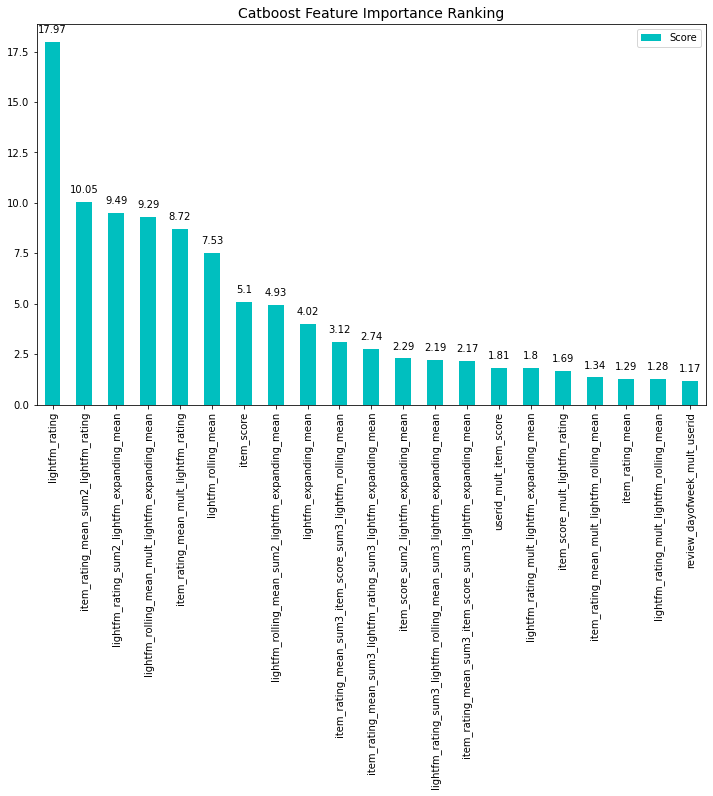

In [338]:
plt.rcParams["figure.figsize"] = (12,7)
ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
ax.set_xlabel('')

rects = ax.patches

labels = feature_score['Score'].round(2)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

plt.show()

In [231]:
model = CatBoostRegressor(
    l2_leaf_reg=int(best['l2_leaf_reg']),
    learning_rate=best['learning_rate'],
    iterations=750,
    eval_metric='AUC',
    random_seed=42,
    verbose=True,
    loss_function='RMSE',
)


In [ ]:
cv_data = cv(Pool(X_train, y_train), model.get_params())

In [ ]:
cv_data

In [ ]:
model.fit(X_train, y_train, plot=True)

In [ ]:
# Get predictions
predictions_catboost = model.predict(X_test)
print(predictions_catboost[:10])

Теперь хочу просто перебрать много вариантов предсказаний катбуста с разными параметрами и просто усредить и посмотреть, что получится.

In [232]:
RANDOM_STATE = 900

CATBOOST_PARAMS_GENERATOR_VER = 11

catbr_params = {
    'random_seed': RANDOM_STATE, 
    'learning_rate': 0.2, #0.2-оптимальный параметр
    'iterations': 750, #750-оптимальный параметр
    'depth': 9, # 9-оптимальный параметр
    'l2_leaf_reg': 3, # 3-оптимальный параметр
    'eval_metric': 'AUC',
    'subsample' : 0.75,
    'random_strength': 0.06, 
    'od_type': "Iter", #детектор переобучения catboost
    'od_wait': 1500,  # 1500-оптимальный параметр 
    'loss_function': 'RMSE',
    'verbose': False, 
}

In [345]:
import random

col_mean = []

result_pred_df = pd.DataFrame()

for i in range(30):
    # Params rendomizer
    catbr_params['subsample'] = random.choice([0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95])
    catbr_params['learning_rate'] = random.choice([0.3, 0.1, 0.2, 0.4])
    catbr_params['depth'] = random.choice([2, 4, 6, 7, 8, 9])
    catbr_params['l2_leaf_reg'] = random.choice([0.85, 0.9, 0.95, 1.0, 1.05, 1.1, 1.15, 1.2, 1.25])
    catbr_params['random_seed'] = random.randint(10,10000)
    predict_model_ = 'result' + str(CATBOOST_PARAMS_GENERATOR_VER) + str(i) + "_subs_" + str(catbr_params['subsample'])+  "_lr_" + str(catbr_params['learning_rate'])+ "_l2_" + str(catbr_params['l2_leaf_reg'])+\
            "_rs_" + str(catbr_params['random_seed'])
      
    # Model
    model = CatBoostRegressor(**catbr_params)
    
    # Model fit
    model.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
#     cat_features=categorical_features_names,
    plot=False
    );
    
    print(i)
    
    # Get predictions
    predict_model_ = model.predict(X_test)
    result_pred_df[f'result_{i}'] = predict_model_
    print(predict_model_[:10])    

    col_mean.extend([predict_model_])
    
print(col_mean)

0
[1.13442008 0.97641027 0.41240282 0.93414849 0.97275364 1.00896609
 0.79048465 0.96732313 0.81740614 0.79925056]
1
[ 1.00288407  0.86540037 -0.17586723  0.8879164   0.88944937  1.01858837
  0.61186225  0.96909092  0.82714037  0.73975456]
2
[0.95980366 0.77616986 0.49252679 0.77980129 0.73418419 0.80435865
 0.73226739 0.93911475 0.8315617  0.73104581]
3
[1.05438292 0.75201724 0.49170775 0.80869496 0.6388998  0.84370204
 0.7959706  0.95556939 0.82245118 0.77042298]
4
[1.13819839 0.68003458 0.21743798 0.72782833 0.77093649 0.77917768
 0.79533763 0.96953981 0.8121047  0.78933369]
5
[1.14024029 0.82330117 0.24126062 0.55638963 0.60094491 0.80374164
 0.76248757 0.97475389 0.75985657 0.79203762]
6
[1.16065525 0.93607222 0.44922183 1.01510996 0.87738563 1.14599037
 0.68731127 0.97772249 0.94205366 0.80202858]
7
[ 1.08875014  0.70028697 -0.32578575  0.95952876  0.96269588  0.84322365
  0.71984029  0.95204035  0.76553752  0.80732844]
8
[1.104331   0.86524104 0.41186604 0.97558486 1.01105095 1.

In [346]:
col_list = result_pred_df.columns.tolist()
result_pred_df['y_pred_v0'] = result_pred_df[col_list].mean(axis = 1)

In [347]:
result_pred_df

,result_0,result_1,result_2,result_3,result_4,result_5,result_6,result_7,result_8,result_9,...,result_21,result_22,result_23,result_24,result_25,result_26,result_27,result_28,result_29,y_pred_v0
0,1.134420,1.002884,0.959804,1.054383,1.138198,1.140240,1.160655,1.088750,1.104331,1.065785,...,0.925762,1.127359,0.993763,1.069231,1.071472,1.191638,1.034278,1.135247,0.536962,1.039568
1,0.976410,0.865400,0.776170,0.752017,0.680035,0.823301,0.936072,0.700287,0.865241,0.789150,...,0.717243,0.529113,0.654744,0.521019,0.899497,0.992604,0.999143,1.074285,0.858150,0.800460
2,0.412403,-0.175867,0.492527,0.491708,0.217438,0.241261,0.449222,-0.325786,0.411866,0.341953,...,0.605287,0.443932,0.551331,0.512594,0.258018,0.605266,0.519288,-0.068737,0.274474,0.347240
3,0.934148,0.887916,0.779801,0.808695,0.727828,0.556390,1.015110,0.959529,0.975585,0.658361,...,0.930843,0.599338,0.850777,0.650231,1.003081,1.035937,0.850457,0.744380,0.780280,0.859936
4,0.972754,0.889449,0.734184,0.638900,0.770936,0.600945,0.877386,0.962696,1.011051,0.727871,...,1.009734,0.723537,0.950062,0.563357,1.007378,0.874522,0.752807,0.823030,0.723638,0.843537
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285960,0.868956,0.815608,0.706423,0.710580,0.833067,0.765967,0.748330,0.804264,0.816879,0.782238,...,0.662436,0.734463,0.735325,0.751685,0.825304,0.750855,0.810083,0.892951,0.728047,0.768383
285961,0.216631,0.316050,-0.013287,0.287280,0.272584,0.419459,0.383123,0.298052,0.199341,0.281953,...,0.265688,0.107216,0.512933,0.451196,0.261027,0.485030,0.399898,0.470340,0.194008,0.300222
285962,0.740987,0.652055,0.614026,0.648165,0.718133,0.721568,0.756157,0.687922,0.709665,0.718116,...,0.720533,0.599688,0.681138,0.742292,0.717504,0.732868,0.695338,0.736064,0.332024,0.662568
285963,0.879345,0.801904,0.902268,0.896779,0.894000,0.938912,0.880169,0.889506,0.891874,0.891479,...,0.879146,0.860368,0.915836,0.903149,0.880165,0.868875,0.873154,0.846534,0.928916,0.874218


In [348]:
predictions_catboost = result_pred_df['y_pred_v0'].values

In [ ]:
predictions_catboost.min(), predictions_catboost.max()

In [349]:
normalized_predictions_catboost = (predictions_catboost - predictions_catboost.min())/(predictions_catboost - predictions_catboost.min()).max()
normalized_predictions_catboost

array([0.92321718, 0.74590321, 0.40981051, ..., 0.64364702, 0.80059921,
       0.8686381 ])

In [350]:
normalized_preds = (normalized_predictions_catboost + test_normalized_preds_lightfm) / 2

# Submission

In [351]:
submission['rating'] = normalized_preds

In [ ]:
submission

In [352]:
VERSION = 29

In [353]:
submission.to_csv(f'submission_log_v{VERSION}.csv', index=False)